In [1]:
%load_ext autoreload
%autoreload 2

In [3]:
import numpy as np
import pandas as pd
from datasets import load_dataset, load_from_disk

In [4]:
load_from_disk("../data/processed/imdb/train/").to_pandas()[["labels"]].to_csv(
    "labels.tsv", sep="\t"
)

/home/pl487/.conda/envs/allset/lib/python3.9/site-packages/datasets/arrow_dataset.py:1533: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [6]:
embeddings = np.load("../data/processed/imdb/imdb_index.npy")
np.savetxt(fname="embeddings.tsv", X=embeddings, delimiter="\t")

In [8]:
pd.DataFrame(embeddings).to_csv(sep="\t", header=False)

In [ ]:
pd.DataFrame(labels, columns=["labels"]).to_csv(sep="\t")

In [9]:
# dataset_dict = load_dataset("ag_news")
dataset_dict = load_dataset("imdb")
df = pd.concat(
    [
        dataset_dict[split].to_pandas().assign(split=split)
        for split in dataset_dict
        if split in ["train", "test"]
    ]
)

Found cached dataset imdb (/home/pl487/.cache/huggingface/datasets/imdb/plain_text/1.0.0/d613c88cf8fa3bab83b4ded3713f1f74830d1100e171db75bbddb80b3345c9c0)


  0%|          | 0/3 [00:00<?, ?it/s]

In [31]:
ds = load_from_disk("/home/pl487/allset/data/processed/imdb")

/home/pl487/.conda/envs/allset/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [35]:
df = ds["train"].to_pandas()

In [25]:
df = load_from_disk("../data/prepared/agnews_bert_tiny/")["train"].to_pandas()

/home/pl487/.conda/envs/allset/lib/python3.9/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


<AxesSubplot: >

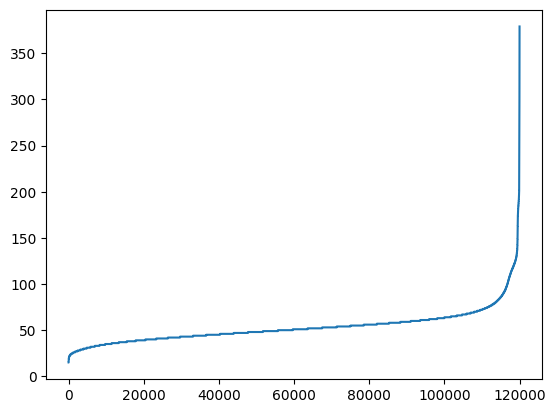

In [27]:
df["input_ids"].map(len).plot()

In [2]:
import time
from pathlib import Path

import pandas as pd
import srsly
from datasets import load_from_disk
from torch.utils.data import DataLoader
from tqdm.auto import tqdm, trange
from transformers import AutoModelForSequenceClassification, AutoTokenizer

from src.data.active_datamodule import ActiveClassificationDataModule
from src.data.datamodule import ClassificationDataModule
from src.enums import SpecialKeys
from src.estimator import Estimator
from src.huggingface import (
    EstimatorForSequenceClassification,
    UncertaintyBasedStrategyForSequenceClassification,
)

In [3]:
data_path = Path("../data/prepared/ag_news")
dataset_dict = load_from_disk(data_path)
metadata = srsly.read_yaml(data_path / "metadata.yaml")

/Users/pietrolesci/miniconda3/envs/fila/lib/python3.8/site-packages/datasets/dataset_dict.py:1241: FutureWarning: 'fs' was is deprecated in favor of 'storage_options' in version 2.8.0 and will be removed in 3.0.0.
You can remove this warning by passing 'storage_options=fs.storage_options' instead.
  warnings.warn(


In [4]:
tokenizer = AutoTokenizer.from_pretrained(metadata["name_or_path"])

In [5]:
datamodule = ClassificationDataModule.from_dataset_dict(
    dataset_dict, tokenizer=tokenizer
)

In [6]:
model = AutoModelForSequenceClassification.from_pretrained(
    metadata["name_or_path"],
    num_labels=len(datamodule.labels),
    id2label=datamodule.id2label,
    label2id=datamodule.label2id,
)

Some weights of the model checkpoint at google/bert_uncased_L-2_H-128_A-2 were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification w

In [7]:
estimator = EstimatorForSequenceClassification(model)

In [8]:
out = estimator.fit(
    train_loader=datamodule.train_loader(),
    validation_loader=datamodule.validation_loader(),
    limit_train_batches=10,
    limit_validation_batches=10,
    num_epochs=1,
)

Completed epochs:   0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/3275 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

In [9]:
active_estimator = UncertaintyBasedStrategyForSequenceClassification(
    model, score_fn="margin_confidence"
)

In [10]:
out = active_estimator.fit(
    train_loader=datamodule.train_loader(),
    validation_loader=datamodule.validation_loader(),
    limit_train_batches=10,
    limit_validation_batches=10,
)

Completed epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/3275 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/3275 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/3275 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

In [11]:
active_datamodule = ActiveClassificationDataModule.from_dataset_dict(
    dataset_dict,
    tokenizer=tokenizer,
)

In [12]:
active_out = active_estimator.active_fit(
    active_datamodule=active_datamodule,
    num_rounds=3,
    query_size=50,
    val_perc=0.3,
    fit_kwargs={
        "num_epochs": 3,
        "limit_train_batches": 3,
        "limit_validation_batches": 3,
    },
    test_kwargs={"limit_batches": 3},
    pool_kwargs={"limit_batches": 3},
)

Completed labelling rounds:   0%|          | 0/3 [00:00<?, ?it/s]

Test:   0%|          | 0/238 [00:00<?, ?it/s]

Pool:   0%|          | 0/3275 [00:00<?, ?it/s]

Completed epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/2 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Test:   0%|          | 0/238 [00:00<?, ?it/s]

Pool:   0%|          | 0/3274 [00:00<?, ?it/s]

Completed epochs:   0%|          | 0/3 [00:00<?, ?it/s]

Epoch 0:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Epoch 2:   0%|          | 0/4 [00:00<?, ?it/s]

Validation:   0%|          | 0/475 [00:00<?, ?it/s]

Test:   0%|          | 0/238 [00:00<?, ?it/s]

Pool:   0%|          | 0/3272 [00:00<?, ?it/s]

In [16]:
active_datamodule.save_labelled_dataset("results")

In [17]:
df = pd.read_parquet("results/labelled_dataset.parquet")

In [18]:
df

,text,labels,id,is_labelled,is_validation,labelling_round
0,Wall St. Bears Claw Back Into the Black (Reute...,2,0,True,False,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2,1,True,False,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2,2,False,False,-1
3,Iraq Halts Oil Exports from Main Southern Pipe...,2,3,True,False,0
4,"Oil prices soar to all-time record, posing new...",2,4,True,False,0
...,...,...,...,...,...,...
104795,Pakistan's Musharraf Says Won't Quit as Army C...,0,104795,False,False,-1
104796,Renteria signing a top-shelf deal Red Sox gene...,1,104796,False,False,-1
104797,Saban not going to Dolphins yet The Miami Dolp...,1,104797,False,False,-1
104798,Today's NFL games PITTSBURGH at NY GIANTS Time...,1,104798,False,False,-1
